In [1]:
#https://ieeexplore.ieee.org/document/10549889

In [2]:
!pip install openpyxl ssqueezepy pyts

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.4 MB/s eta 0:00:00:00:01


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.applications import ResNet50
from ssqueezepy import cwt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import pywt
import pyts
import matplotlib.pyplot as plt

2025-01-05 17:40:48.817187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 17:40:48.817264: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 17:40:48.817299: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 17:40:48.826387: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [7]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [8]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [9]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [10]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [11]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

/tmp/ipykernel_130/2481253413.py:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [12]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

/tmp/ipykernel_130/4217821953.py:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [13]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [14]:
trainy = trainy - 3
testy = testy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [15]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (4067, 128, 9)
Y train shape:  (4067, 1)
Y train One hot shape:  (4067, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)


In [16]:
# trainX, valX, trainy, valy = train_test_split(trainX, trainy,test_size=0.3)

# Min-Max Scaling -> Transformer

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaling
scaler_minmax = MinMaxScaler()

# 데이터 평탄화 후 스케일링
trainX_flat_minmax = trainX.reshape(-1, 9)
testX_flat_minmax = testX.reshape(-1, 9)
# valX_flat_minmax = valX.reshape(-1, 9)

trainX_minmax = scaler_minmax.fit_transform(trainX_flat_minmax)
testX_minmax = scaler_minmax.transform(testX_flat_minmax)
# valX_minmax = scaler_minmax.transform(valX_flat_minmax)

# 원래 형태로 변환
trainX_minmax = trainX_minmax.reshape(4067, 128, 9)
testX_minmax = testX_minmax.reshape(1560, 128, 9)

print("MinMax Scaled trainX shape:", trainX_minmax.shape)
print("MinMax Scaled testX shape:", testX_minmax.shape)

MinMax Scaled trainX shape: (4067, 128, 9)
MinMax Scaled testX shape: (1560, 128, 9)


In [18]:
from tensorflow.keras import layers, models
import tensorflow as tf

def reshape_to_transformer_input(data):
    """
    데이터 형태를 Transformer 입력에 맞게 조정
    Input: (None, 128, 9)
    Output: (None, 128, 256)
    """
    input_layer = layers.Input(shape=(128, 9))
    x = layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='same')(input_layer)
    x = layers.LayerNormalization()(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=x)
    return model(data).numpy()

# 데이터 변환
trainX_transformer = reshape_to_transformer_input(trainX_minmax)
testX_transformer = reshape_to_transformer_input(testX_minmax)

print("Transformer-ready trainX shape:", trainX_transformer.shape)  # (4067, 128, 256)
print("Transformer-ready testX shape:", testX_transformer.shape)    # (1560, 128, 256)


2025-01-05 17:40:56.633796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:cc:00.0, compute capability: 8.0
2025-01-05 17:40:56.636043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0
2025-01-05 17:40:57.243500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907


Transformer-ready trainX shape: (4067, 128, 256)
Transformer-ready testX shape: (1560, 128, 256)


# MinMax Scaling -> Spectrogram -> ResNet50

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import os

# Spectrogram transformation function
def generate_spectrogram(data, output_dir, sample_rate=1.0):
    os.makedirs(output_dir, exist_ok=True)
    
    num_samples = data.shape[0]
    spectrogram_images = []
    
    for i in range(num_samples):
        signal = data[i].T  # Transpose to get signals from each sensor
        
        fig, axs = plt.subplots(signal.shape[0], 1, figsize=(4, 4 * signal.shape[0]))
        if signal.shape[0] == 1:
            axs = [axs]

        for j in range(signal.shape[0]):
            f, t, Sxx = spectrogram(signal[j], fs=sample_rate, nperseg=64, noverlap=32)
            axs[j].imshow(10 * np.log10(Sxx + 1e-10), aspect='auto', cmap='jet', origin='lower')
            axs[j].set_title(f'Sensor {j+1} Spectrogram')
            axs[j].axis('off')

        plt.tight_layout()
        img_path = os.path.join(output_dir, f'sample_{i}.png')
        plt.savefig(img_path, bbox_inches='tight')
        plt.close(fig)
        spectrogram_images.append(img_path)

    return spectrogram_images

# Example usage
# Assuming X_train shape: (4067, 128, 9), X_test shape: (1560, 128, 9)
sample_rate = 50  # Adjust based on your dataset(UCI_HAR의 경우 50)
output_dir_train = "spectrogram_train"
output_dir_test = "spectrogram_test"

# Generate spectrogram images for train and test datasets
trainX_resnet = generate_spectrogram(trainX_minmax, output_dir_train, sample_rate)
testX_resnet = generate_spectrogram(testX_minmax, output_dir_test, sample_rate)

print(f"Generated {len(trainX_resnet)} spectrograms for training data.")
print(f"Generated {len(testX_resnet)} spectrograms for test data.")

Generated 4067 spectrograms for training data.
Generated 1560 spectrograms for test data.


MinMaxScaler Train Mean: 0.5630300374009914
MinMaxScaler Test Mean: 0.5603034299636255
Train Files: ['sample_0.png', 'sample_1.png', 'sample_10.png', 'sample_100.png', 'sample_1000.png']
Test Files: ['sample_0.png', 'sample_1.png', 'sample_10.png', 'sample_100.png', 'sample_1000.png']


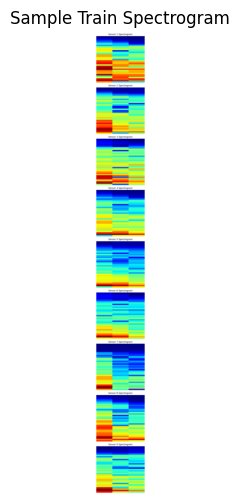

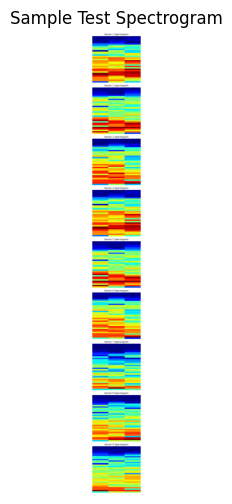

In [26]:
# MinMaxScaler 데이터 확인
print("MinMaxScaler Train Mean:", trainX_minmax.mean())
print("MinMaxScaler Test Mean:", testX_minmax.mean())

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os

# 이미지가 저장된 디렉터리 경로 설정 (사용자의 실제 경로로 변경 필요)
output_dir_train = './spectrogram_train'
output_dir_test = './spectrogram_test'

# 디렉터리에서 파일 목록 가져오기
train_files = sorted([f for f in os.listdir(output_dir_train) if f.endswith('.png')])
test_files = sorted([f for f in os.listdir(output_dir_test) if f.endswith('.png')])

print("Train Files:", train_files[:5])  # 첫 5개 파일 확인
print("Test Files:", test_files[:5])    # 첫 5개 파일 확인


# 첫 번째 Train Spectrogram 이미지 확인
sample_train_image_path = os.path.join(output_dir_train, train_files[0])
sample_test_image_path = os.path.join(output_dir_test, test_files[0])

# Train 이미지 확인
img_train = mpimg.imread(sample_train_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img_train)
plt.title("Sample Train Spectrogram")
plt.axis('off')
plt.show()

# Test 이미지 확인
img_test = mpimg.imread(sample_test_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img_test)
plt.title("Sample Test Spectrogram")
plt.axis('off')
plt.show()

# Cross-Attention Model

In [39]:
def transformer_encoder(inputs, num_heads=4, ff_dim=256):
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    x = layers.LayerNormalization()(x)
    
    x_ff = layers.Dense(ff_dim, activation='relu')(x)
    x_ff = layers.LayerNormalization()(x_ff)
    
    return layers.GlobalAveragePooling1D()(x_ff)


def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape, name='Transformer_Input')
    x = transformer_encoder(inputs)
    x = layers.Dense(128, activation='relu')(x)
    return models.Model(inputs, x, name='Transformer_Model')


In [40]:
def build_resnet_model(input_shape):
    inputs = Input(shape=input_shape, name='Spectrogram_Input')
    
    # 초기 Conv Block
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # 두 번째 Conv Block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # 세 번째 Conv Block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    return models.Model(inputs, x, name='ResNet_Spectrogram_Model')


In [41]:
def cross_attention_block(transformer_feature, resnet_feature, ff_dim=256, num_heads=4):
    # Feature Dimension 확장
    transformer_feature = tf.expand_dims(transformer_feature, axis=1)
    resnet_feature = tf.expand_dims(resnet_feature, axis=1)
    
    # Cross Attention 적용
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=ff_dim
    )(transformer_feature, resnet_feature)
    
    # Add & Normalize
    x = layers.Add()([transformer_feature, attention_output])
    x = layers.LayerNormalization()(x)
    
    # Feed-Forward Network
    x = layers.Dense(ff_dim, activation='relu')(x)
    x = layers.LayerNormalization()(x)
    
    # Flatten
    x = tf.squeeze(x, axis=1)
    return x


In [42]:
def build_cross_attention_model(transformer_shape, spectrogram_shape, num_classes):
    # Transformer Input (시계열 입력)
    transformer_input = Input(shape=transformer_shape, name='Transformer_Input')
    transformer_output = build_transformer_model(transformer_shape)(transformer_input)
    
    # ResNet Input (Spectrogram 이미지 입력)
    spectrogram_input = Input(shape=spectrogram_shape, name='Spectrogram_Input')
    spectrogram_output = build_resnet_model(spectrogram_shape)(spectrogram_input)
    
    # Cross-Attention 통합
    fused_features = cross_attention_block(transformer_output, spectrogram_output)
    fused_features = layers.Dense(256, activation='relu')(fused_features)
    fused_features = layers.Dropout(0.3)(fused_features)
    
    # 최종 출력
    output = layers.Dense(num_classes, activation='softmax')(fused_features)
    
    # 최종 모델 생성
    model = models.Model(
        inputs=[transformer_input, spectrogram_input],
        outputs=output,
        name='CrossAttention_Spectrogram_Model'
    )
    return model


In [43]:
# 모델 생성
cross_attention_model = build_cross_attention_model(
    transformer_shape=(128, 256),  # Transformer 입력 형태 (시계열)
    spectrogram_shape=(128, 128, 3),  # Spectrogram 이미지 형태 (3 채널로 가정)
    num_classes=3
)

# 모델 컴파일
cross_attention_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 요약
cross_attention_model.summary()


Model: "CrossAttention_Spectrogram_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Transformer_Input (InputLa  [(None, 128, 256)]           0         []                            
 yer)                                                                                             
                                                                                                  
 Spectrogram_Input (InputLa  [(None, 128, 128, 3)]        0         []                            
 yer)                                                                                             
                                                                                                  
 Transformer_Model (Functio  (None, 128)                  1151616   ['Transformer_Input[0][0]']   
 nal)                                                              

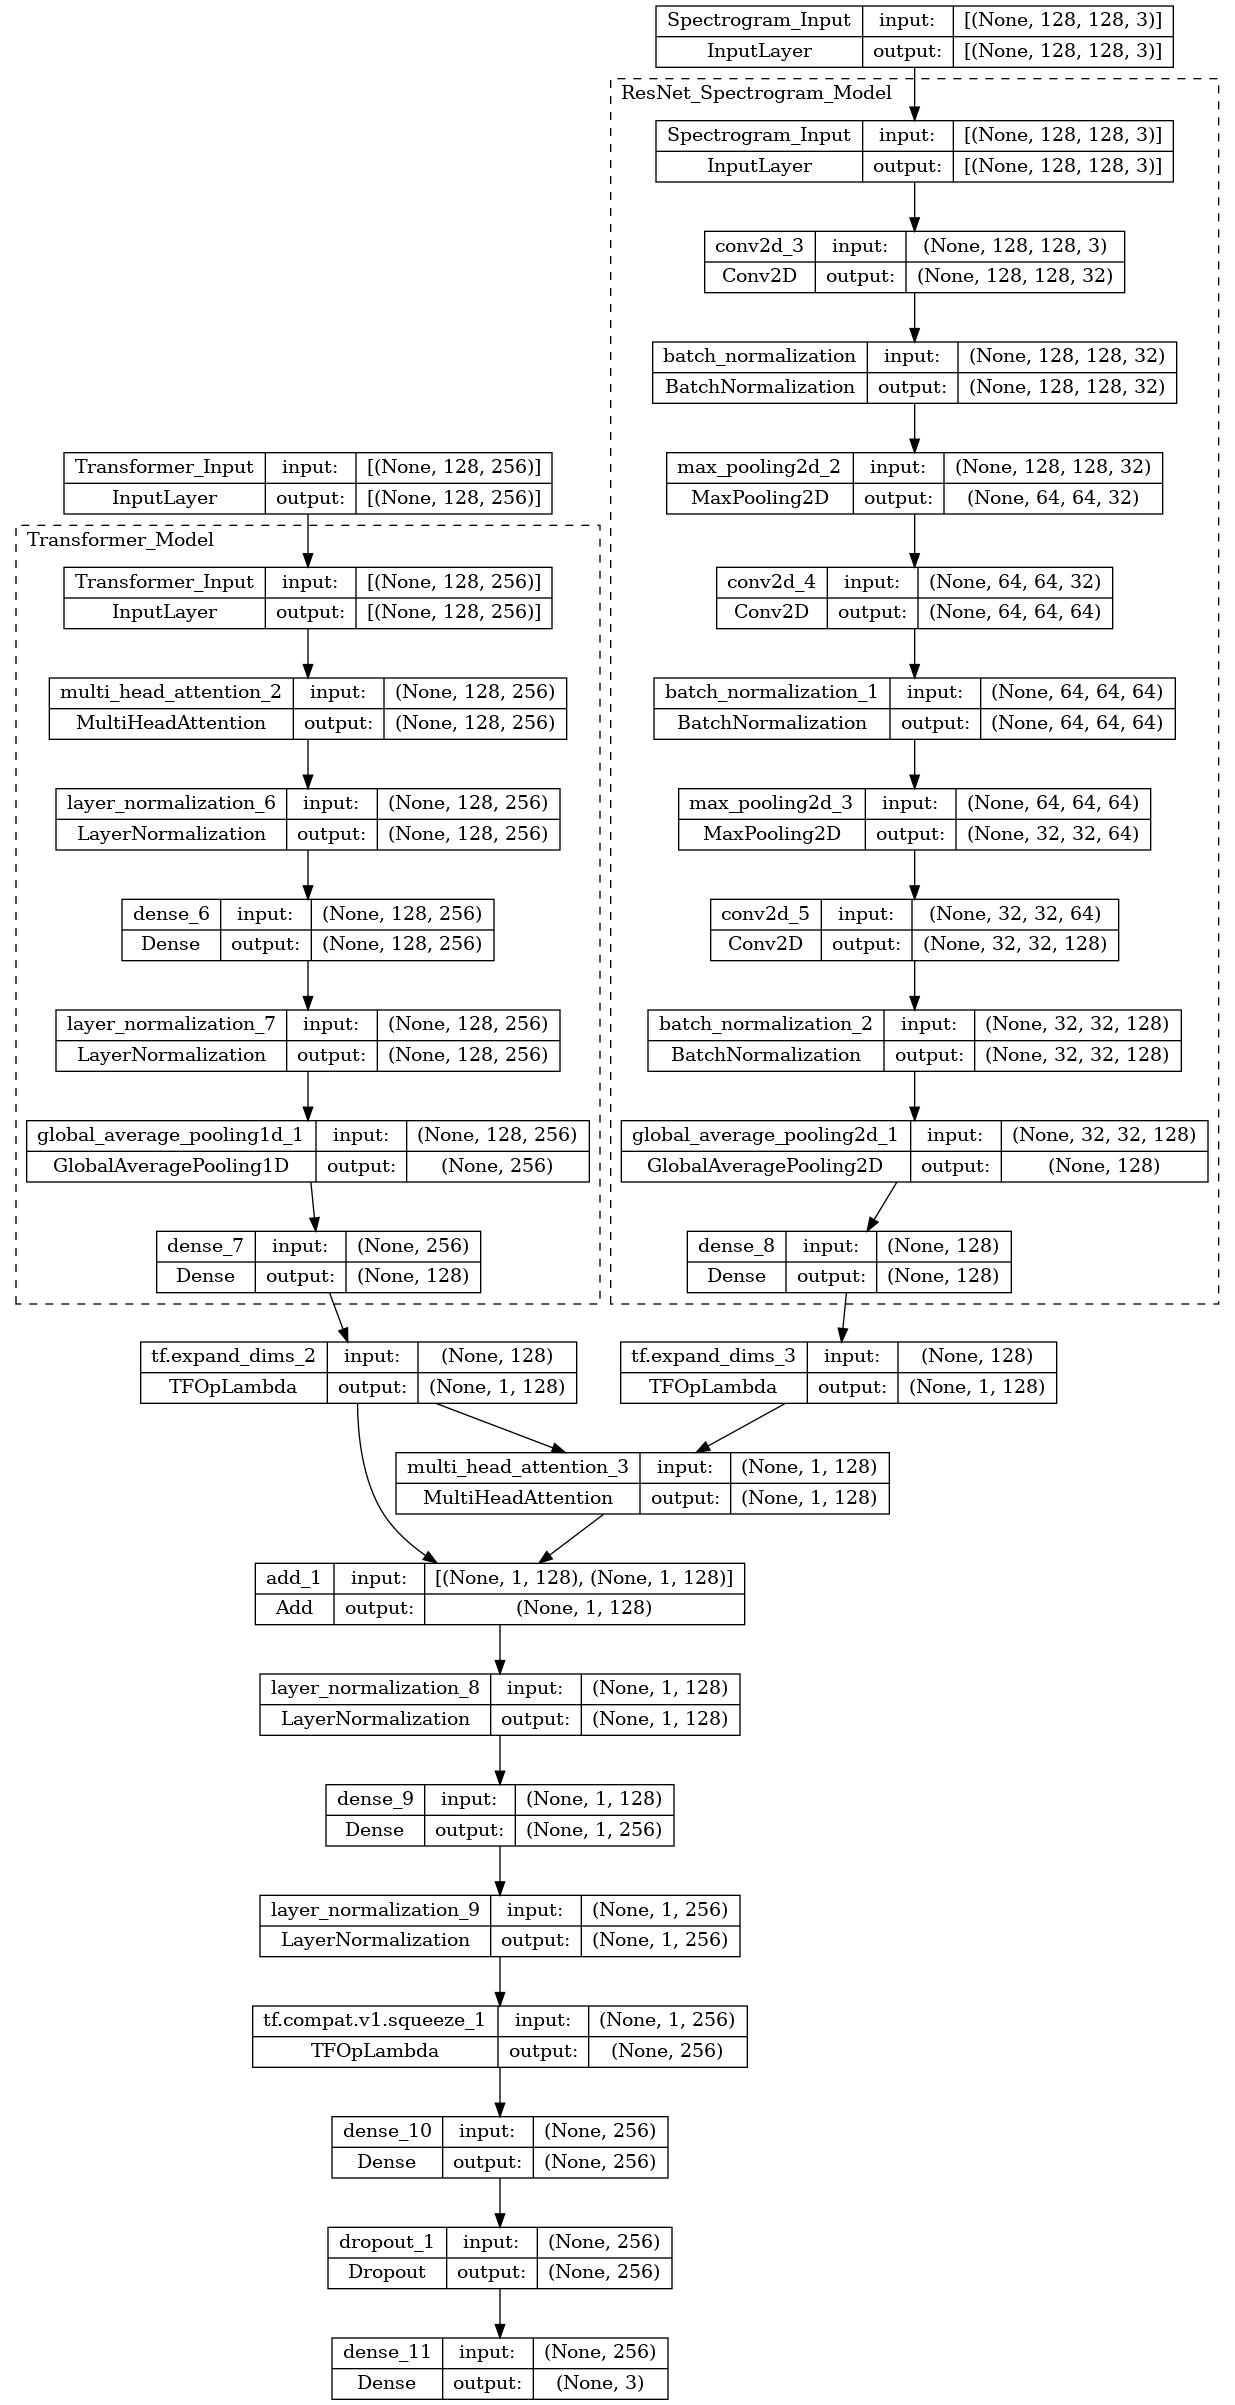

In [44]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    cross_attention_model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [49]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 이미지 로드 및 전처리 함수
def load_and_preprocess_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  # 이미지 로드 및 리사이즈
        img = img_to_array(img)  # NumPy 배열로 변환
        img = img / 255.0  # 정규화 (0~1 범위)
        images.append(img)
    return np.array(images)

In [50]:
# ResNet 입력 데이터 변환 (이미지 파일 -> NumPy 배열)
trainX_resnet_np = load_and_preprocess_images(trainX_resnet, target_size=(128, 128))

In [45]:
trainX_transformer.shape

(4067, 128, 256)

In [51]:
trainX_resnet_np.shape

(4067, 128, 128, 3)

In [52]:
# 모델 학습
# EarlyStopping 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
history = cross_attention_model.fit(
    [trainX_transformer, trainX_resnet_np],
    trainy_one_hot,
    validation_split = 0.3,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/100


2025-01-05 19:04:45.935978: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1b1d00ca60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-05 19:04:45.936009: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2025-01-05 19:04:45.936016: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2025-01-05 19:04:45.941486: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-05 19:04:46.022392: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


89/89 [==============================] - 10s 36ms/step - loss: 0.6923 - accuracy: 0.6497 - val_loss: 0.5828 - val_accuracy: 0.8829
Epoch 2/100
89/89 [==============================] - 2s 22ms/step - loss: 0.3490 - accuracy: 0.8584 - val_loss: 0.6231 - val_accuracy: 0.9353
Epoch 3/100
89/89 [==============================] - 2s 20ms/step - loss: 0.2828 - accuracy: 0.8809 - val_loss: 0.7412 - val_accuracy: 0.8821
Epoch 4/100
89/89 [==============================] - 2s 20ms/step - loss: 0.2134 - accuracy: 0.9100 - val_loss: 0.5022 - val_accuracy: 0.9386
Epoch 5/100
89/89 [==============================] - 2s 21ms/step - loss: 0.2138 - accuracy: 0.9129 - val_loss: 0.9379 - val_accuracy: 0.7846
Epoch 6/100
89/89 [==============================] - 2s 21ms/step - loss: 0.1897 - accuracy: 0.9294 - val_loss: 0.4599 - val_accuracy: 0.9312
Epoch 7/100
89/89 [==============================] - 2s 21ms/step - loss: 0.2124 - accuracy: 0.9090 - val_loss: 0.7178 - val_accuracy: 0.8771
Epoch 8/100
89/89

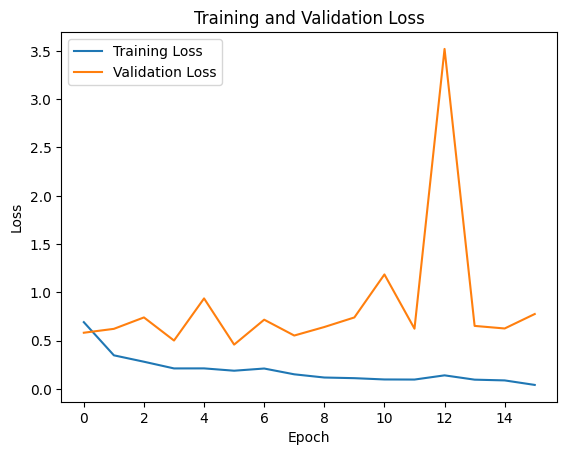

In [53]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

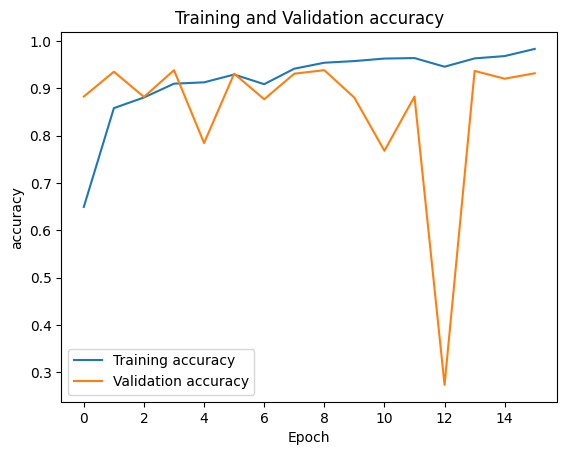

In [54]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.show()

In [55]:
# ResNet 입력 데이터 변환 (이미지 파일 -> NumPy 배열)
testX_resnet_np = load_and_preprocess_images(testX_resnet, target_size=(128, 128))

49/49 [==============================] - 1s 9ms/step
Classification Report:
              precision    recall  f1-score   support

     SITTING       0.46      0.43      0.44       491
    STANDING       0.45      0.92      0.60       532
      LAYING       0.00      0.00      0.00       537

    accuracy                           0.45      1560
   macro avg       0.30      0.45      0.35      1560
weighted avg       0.30      0.45      0.34      1560

Test Accuracy: 0.45


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


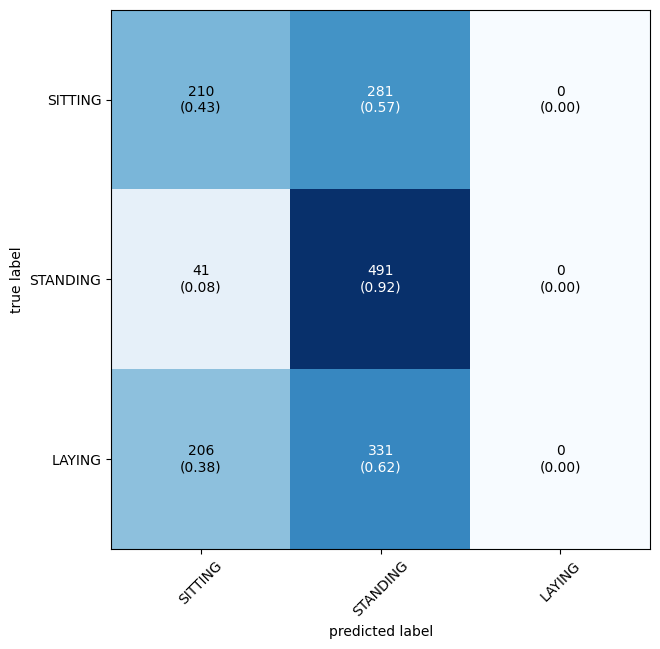

In [56]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# 예측 수행
predy = cross_attention_model.predict([testX_transformer, testX_resnet_np])
predy = np.argmax(predy, axis=-1)  # 가장 확률이 높은 클래스를 선택

# 테스트 라벨 (One-Hot Encoding → 정수형 라벨 변환)
testy = np.argmax(testy_one_hot, axis=-1)  # 테스트 레이블 변환

# 라벨 정의
LABELS = ['SITTING', 'STANDING', 'LAYING']

# 혼동 행렬 생성
cm = confusion_matrix(testy, predy)

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# 성능 보고서 출력
print("Classification Report:")
print(classification_report(testy, predy, target_names=LABELS))

# 정확도 출력
accuracy = accuracy_score(testy, predy)
print(f"Test Accuracy: {accuracy:.2f}")


In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))

[[210 281   0]
 [ 41 491   0]
 [206 331   0]]
0.4493589743589744
0.34426732553372896
              precision    recall  f1-score   support

           0       0.46      0.43      0.44       491
           1       0.45      0.92      0.60       532
           2       0.00      0.00      0.00       537

    accuracy                           0.45      1560
   macro avg       0.30      0.45      0.35      1560
weighted avg       0.30      0.45      0.34      1560



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
